In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 200

random_seed = 1
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
      batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
      batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

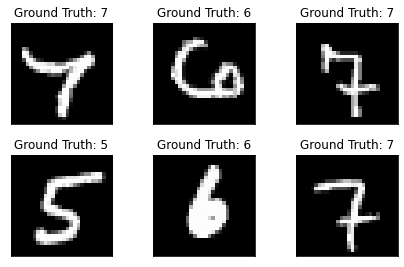

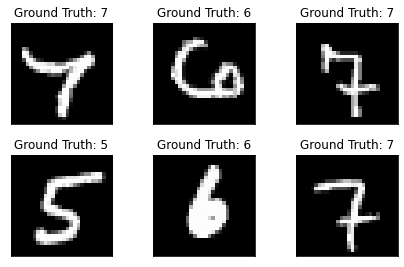

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [9]:
network = Net().cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(network.state_dict(), './model.pth')
        torch.save(optimizer.state_dict(), './optimizer.pth')

In [12]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/lustre/share/conda_env/pytorch/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316513
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.114166
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.741095
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.666700
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.873132

Test set: Avg. loss: 0.2010, Accuracy: 9442/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.355070
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.276870
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.324565
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.585722
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.324434

Test set: Avg. loss: 0.1179, Accuracy: 9663/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.262130
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.332813
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.342111
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.464622
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.154457

Test set: Avg. loss: 0.0933, Accuracy: 9717/10000 (97%)



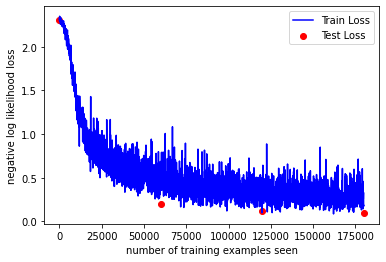

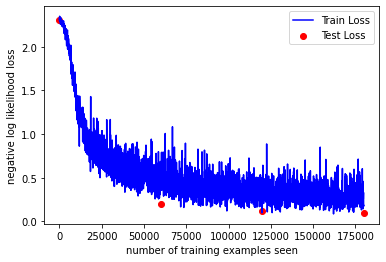

In [14]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig